In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re
from pyvi.ViTokenizer import tokenize

In [2]:
import joblib

In [3]:
df1= pd.read_csv('Data_Agoda_raw/hotel_info.csv')
df1.head()

,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,4,1_4,Panorama Star Beach Nha Trang,5 sao trên 5,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V...","8,8","9,6","8,9","8,9","8,7","9,0",NaN,814,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,5,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,4 sao trên 5,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,4","8,5","8,7","8,5","8,3","8,6","8,7",294,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

In [5]:
num_cols = ["Total_Score", "Location", "Cleanliness", "Service","Facilities", "Value_for_money", "Comfort_and_room_quality", "comments_count"]

In [6]:
dirty_vals = ["no information", "nan", "none", "null", "", "na"]

In [7]:
# Chọn các cột object
obj_cols = df1.select_dtypes(include=["object"]).columns

summary = {}
for col in obj_cols:
    # Lấy tất cả giá trị duy nhất trong cột (chuẩn hóa về chữ thường)
    unique_vals = df1[col].astype(str).str.strip().str.lower().unique()
    
    # Kiểm tra giao giữa unique_vals và dirty_vals
    dirty_found = set(unique_vals) & set(dirty_vals)
    
    if dirty_found:
        summary[col] = list(dirty_found)
summary

{'Hotel_Rank': ['no information'],
 'Total_Score': ['no information'],
 'Location': ['nan'],
 'Cleanliness': ['nan'],
 'Service': ['nan'],
 'Facilities': ['nan'],
 'Value_for_money': ['nan'],
 'Comfort_and_room_quality': ['nan'],
 'Hotel_Description': ['nan']}

In [8]:
for col in num_cols:
    df1[col] = (
        df1[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace(dirty_vals, np.nan)
        .str.replace(",", ".", regex=False)
    )
    df1[col] = pd.to_numeric(df1[col], errors="coerce")

In [9]:
df1['Hotel_Rank'] = df1['Hotel_Rank'].astype(str).str.strip().str.lower().replace(dirty_vals,np.nan)

In [10]:
df1["Hotel_Rank_Num"] = df1["Hotel_Rank"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   Hotel_ID                  740 non-null    object 
 2   Hotel_Name                740 non-null    object 
 3   Hotel_Rank                267 non-null    object 
 4   Hotel_Address             740 non-null    object 
 5   Total_Score               414 non-null    float64
 6   Location                  413 non-null    float64
 7   Cleanliness               412 non-null    float64
 8   Service                   373 non-null    float64
 9   Facilities                370 non-null    float64
 10  Value_for_money           410 non-null    float64
 11  Comfort_and_room_quality  51 non-null     float64
 12  comments_count            740 non-null    int64  
 13  Hotel_Description         739 non-null    object 
 14  Hotel_Rank

In [12]:
cols_to_fill = ["Total_Score", "Location", "Cleanliness", "Service","Facilities", "Value_for_money", "Comfort_and_room_quality","Hotel_Rank_Num"]

for col in cols_to_fill:
    df1[col] = df1[col].fillna(0)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   Hotel_ID                  740 non-null    object 
 2   Hotel_Name                740 non-null    object 
 3   Hotel_Rank                267 non-null    object 
 4   Hotel_Address             740 non-null    object 
 5   Total_Score               740 non-null    float64
 6   Location                  740 non-null    float64
 7   Cleanliness               740 non-null    float64
 8   Service                   740 non-null    float64
 9   Facilities                740 non-null    float64
 10  Value_for_money           740 non-null    float64
 11  Comfort_and_room_quality  740 non-null    float64
 12  comments_count            740 non-null    int64  
 13  Hotel_Description         739 non-null    object 
 14  Hotel_Rank

In [14]:
df1 = df1.drop(columns=["Hotel_Rank"])

In [15]:
df1["Hotel_Description"] = df1["Hotel_Description"].fillna("-")

In [50]:
df1.to_csv("data_clean/hotel_info.csv", index=False, encoding="utf-8-sig")

In [16]:
df2= pd.read_csv('Data_Agoda_raw/hotel_comments.csv')
df2.head()

,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024
3,4,1_1,1_1_4,Nghĩa,Việt Nam,Gia đình có em bé,Deluxe Hướng biển giường đôi,Đã ở 3 đêm vào Tháng 6 năm 2024,"8,8",Tuyệt vời,Du lịch Nha Trang tại Mường Thanh”,Hôm đi đến lúc về thì mọi thứ trong Khách sạn ...,Đã nhận xét vào 02 tháng 7 2024
4,5,1_1,1_1_5,Duc,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Ks tốt !”,Khách sạn có vị trí trung tâm và sát biển. Nhâ...,Đã nhận xét vào 16 tháng 6 2024


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB


In [18]:
df2['Score'] = df2['Score'].astype(str).str.strip().str.lower().replace(dirty_vals, np.nan).str.replace(",", ".", regex=False)

In [19]:
df2["Score"] = df2["Score"].astype(str).str.replace(",", ".").astype(float)

In [20]:
df2.columns = df2.columns.str.strip().str.replace(" ", "_")

In [21]:
df2 = df2.dropna(subset=['Reviewer_Name'])
df2 = df2.dropna(subset=['Body'])

In [22]:
df2 = df2.merge(df1[["Hotel_ID", "Hotel_Name"]], on="Hotel_ID", how="left")
df2.head(2)

,num,Hotel_ID,Reviewer_ID,Reviewer_Name,Nationality,Group_Name,Room_Type,Stay_Details,Score,Score_Level,Title,Body,Review_Date,Hotel_Name
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...


In [23]:
df2["Days"] = df2["Stay_Details"].str.extract(r"Đã ở (\d+) đêm").astype(int)

In [24]:
df2["Month_Stay"] = df2["Stay_Details"].str.extract(r"Tháng\s+(\d+)").astype(int)

In [25]:
df2[["day", "month", "year"]] = df2["Review_Date"].str.extract(r"(\d+)\s+tháng\s+(\d+)\s+(\d+)")

In [26]:
df2["Review_Date"] = pd.to_datetime(df2["day"] + "/" + df2["month"] + "/" + df2["year"], format="%d/%m/%Y")

In [27]:
df2.columns

Index(['num', 'Hotel_ID', 'Reviewer_ID', 'Reviewer_Name', 'Nationality',
       'Group_Name', 'Room_Type', 'Stay_Details', 'Score', 'Score_Level',
       'Title', 'Body', 'Review_Date', 'Hotel_Name', 'Days', 'Month_Stay',
       'day', 'month', 'year'],
      dtype='object')

In [28]:
df2.head(2)

,num,Hotel_ID,Reviewer_ID,Reviewer_Name,Nationality,Group_Name,Room_Type,Stay_Details,Score,Score_Level,Title,Body,Review_Date,Hotel_Name,Days,Month_Stay,day,month,year
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,3,7,30,7,2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,1,9,05,9,2022


In [27]:
df2 = df2.drop(columns=["num","Reviewer_ID","Stay_Details","day","month","year"])

In [28]:
df2["Mean_Reviewer_Score"] = (df2.groupby("Hotel_ID")["Score"].transform("mean"))

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80186 entries, 0 to 80185
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             80186 non-null  object        
 1   Reviewer_Name        80186 non-null  object        
 2   Nationality          80186 non-null  object        
 3   Group_Name           80186 non-null  object        
 4   Room_Type            80186 non-null  object        
 5   Score                80186 non-null  float64       
 6   Score_Level          80186 non-null  object        
 7   Title                80186 non-null  object        
 8   Body                 80186 non-null  object        
 9   Review_Date          80186 non-null  datetime64[ns]
 10  Hotel_Name           69751 non-null  object        
 11  Days                 80186 non-null  int32         
 12  Month_Stay           80186 non-null  int32         
 13  Mean_Reviewer_Score  80186 non-

Những Hotel_ID ở bảng df2 không có tên tại bảng df1 có thể là những hotel_id lỗi không đáng tin tưởng nên drop

In [30]:
df2 = df2.dropna(subset=['Hotel_Name'])

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69751 entries, 0 to 80185
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             69751 non-null  object        
 1   Reviewer_Name        69751 non-null  object        
 2   Nationality          69751 non-null  object        
 3   Group_Name           69751 non-null  object        
 4   Room_Type            69751 non-null  object        
 5   Score                69751 non-null  float64       
 6   Score_Level          69751 non-null  object        
 7   Title                69751 non-null  object        
 8   Body                 69751 non-null  object        
 9   Review_Date          69751 non-null  datetime64[ns]
 10  Hotel_Name           69751 non-null  object        
 11  Days                 69751 non-null  int32         
 12  Month_Stay           69751 non-null  int32         
 13  Mean_Reviewer_Score  69751 non-null 

##### Check dup review, comment 

In [32]:
df2['Review_ID_real'] = (
    df2['Hotel_ID'].astype(str) + '_' +
    df2['Reviewer_Name'].astype(str) + '_' +
    df2['Nationality'].astype(str) + '_' +
    df2['Review_Date'].astype(str) 
)

In [33]:
def check_duplicate_column(df, col_name):
    dup_rows = df[df.duplicated(subset=[col_name])]
    print(f"Số dòng trùng theo cột '{col_name}': {len(dup_rows)}")
    return dup_rows

In [34]:
check_duplicate_column(df2, 'Review_ID_real')

Số dòng trùng theo cột 'Review_ID_real': 43845


,Hotel_ID,Reviewer_Name,Nationality,Group_Name,Room_Type,Score,Score_Level,Title,Body,Review_Date,Hotel_Name,Days,Month_Stay,Mean_Reviewer_Score,Review_ID_real
45,1_1,Minh,Việt Nam,Nhóm,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,8.0,Tuyệt vời,Nóng”,Máy lạnh sảnh và phòng ăn hư. Rất nóng.,2024-06-22,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2,6,9.407407,1_1_Minh_Việt Nam_2024-06-22
46,1_1,Minh,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,8.0,Tuyệt vời,Nóng”,Máy Lạnh sảnh và phòng ăn hư nên rất nóng,2024-06-22,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2,6,9.407407,1_1_Minh_Việt Nam_2024-06-22
73,1_1,LE,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,10.0,Trên cả tuyệt vời,Tốt”,Sẽ quay lại,2024-04-14,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2,2,9.407407,1_1_LE_Việt Nam_2024-04-14
74,1_1,LE,Việt Nam,Cặp đôi,Deluxe 2 giường Hướng phố,10.0,Trên cả tuyệt vời,Tốt”,Sẽ quay lại,2024-04-14,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2,2,9.407407,1_1_LE_Việt Nam_2024-04-14
75,1_1,LE,Việt Nam,Nhóm,Deluxe 2 giường Hướng phố,10.0,Trên cả tuyệt vời,Tốt”,Sẽ quay lại,2024-04-14,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2,2,9.407407,1_1_LE_Việt Nam_2024-04-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79945,39_7,cheng,Trung Quốc,Gia đình có trẻ em,Suite Gia Đình 2 Phòng Ngủ,8.4,Tuyệt vời,性价比很高的家庭酒店”,装修很新，用的是大金空调，东芝洗衣机，设施硬件非常好，有电梯。价格很公道，早餐也不错。隔壁几...,2019-01-26,Khách sạn & Căn hộ Moonlight Bay (Moonlight Ba...,3,1,9.267742,39_7_cheng_Trung Quốc_2019-01-26
79952,39_7,SEJUNG,Hàn Quốc,Du lịch một mình,Phòng Junior Suite,10.0,Trên cả tuyệt vời,나트랑 최고의 가성비호텔”,"총 3박머무는동안 정말 너무만족스러웠구 혼자온 외국인인 저를위한 세심한배려, 사장님...",2022-08-12,Khách sạn & Căn hộ Moonlight Bay (Moonlight Ba...,1,8,9.267742,39_7_SEJUNG_Hàn Quốc_2022-08-12
79979,39_17,Nino,Thụy Sĩ,Cặp đôi,Phòng Tiêu Chuẩn,10.0,Trên cả tuyệt vời,Trên cả tuyệt vời”,Great,2024-03-03,Gold Coast Hotel Nha Trang,1,2,9.288889,39_17_Nino_Thụy Sĩ_2024-03-03
79980,39_17,Nino,Thụy Sĩ,Cặp đôi,Phòng Tiêu Chuẩn,10.0,Trên cả tuyệt vời,Recommend ”,Clean and new. Good location friendly staff,2024-03-03,Gold Coast Hotel Nha Trang,3,2,9.288889,39_17_Nino_Thụy Sĩ_2024-03-03


In [35]:
df2 = df2.drop_duplicates(subset=['Review_ID_real'], keep='first')

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25906 entries, 0 to 80185
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             25906 non-null  object        
 1   Reviewer_Name        25906 non-null  object        
 2   Nationality          25906 non-null  object        
 3   Group_Name           25906 non-null  object        
 4   Room_Type            25906 non-null  object        
 5   Score                25906 non-null  float64       
 6   Score_Level          25906 non-null  object        
 7   Title                25906 non-null  object        
 8   Body                 25906 non-null  object        
 9   Review_Date          25906 non-null  datetime64[ns]
 10  Hotel_Name           25906 non-null  object        
 11  Days                 25906 non-null  int32         
 12  Month_Stay           25906 non-null  int32         
 13  Mean_Reviewer_Score  25906 non-null 

##### Clean body

In [37]:
import re
import pandas as pd
from joblib import Parallel, delayed

In [38]:
# Load dictionary từ file txt
def load_dict(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    return dict(line.strip().split("\t") for line in lines if "\t" in line)

In [39]:
# Load các dict
teencode_dict = load_dict("files/teencode.txt")
english_vn_dict = load_dict("files/english-vnmese.txt")
emoji_dict = load_dict("files/emojicon.txt")

In [41]:
def replace_all_dicts(text, teencode_dict=None, english_vn_dict=None, emoji_dict=None):
    """
    Thay thế theo dict nhưng không dùng regex pattern
    """
    if pd.isna(text):
        return text

    all_dict = {}
    if teencode_dict:
        all_dict.update(teencode_dict)
    if english_vn_dict:
        all_dict.update(english_vn_dict)
    if emoji_dict:
        all_dict.update(emoji_dict)

    # replace lần lượt theo key
    for k, v in all_dict.items():
        if v and isinstance(v, str):   # value không rỗng
            text = text.replace(k, v)

    return text

In [42]:
df2['Body_clean'] = df2['Body'].apply(lambda x: replace_all_dicts(x, teencode_dict, english_vn_dict,emoji_dict))

In [43]:
# Stopwords
stop_words = set()
with open('files/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word:
            stop_words.add(word)

In [44]:
# Wrongwords
wrong_words = set()
with open('files\wrong-word.txt', 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word:
            wrong_words.add(word)

In [45]:
def clean_text_remove_wrong(text, wrong_words, stop_words):
    if pd.isna(text):
        return text
    
    # 1️⃣ loại bỏ các từ sai
    words = text.split()
    words = [w for w in words if w.lower() not in wrong_words]
    
    # 2️⃣ loại bỏ stopwords
    words = [w for w in words if w.lower() not in stop_words] 
    return ' '.join(words)

In [46]:
df2['Body_clean'] = df2['Body'].apply(lambda x: clean_text_remove_wrong(x, wrong_words, stop_words))

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25906 entries, 0 to 80185
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             25906 non-null  object        
 1   Reviewer_Name        25906 non-null  object        
 2   Nationality          25906 non-null  object        
 3   Group_Name           25906 non-null  object        
 4   Room_Type            25906 non-null  object        
 5   Score                25906 non-null  float64       
 6   Score_Level          25906 non-null  object        
 7   Title                25906 non-null  object        
 8   Body                 25906 non-null  object        
 9   Review_Date          25906 non-null  datetime64[ns]
 10  Hotel_Name           25906 non-null  object        
 11  Days                 25906 non-null  int32         
 12  Month_Stay           25906 non-null  int32         
 13  Mean_Reviewer_Score  25906 non-null 

In [53]:
df2.to_csv("data_clean/hotel_comments.csv", index=False, encoding="utf-8-sig")

### EDA

##### EDA

In [49]:
df2["Score"].describe()

count    25906.000000
mean         9.229426
std          0.990941
min          6.300000
25%          8.800000
50%          9.600000
75%         10.000000
max         10.000000
Name: Score, dtype: float64

Số khách đánh giá theo thang điểm

<Axes: >

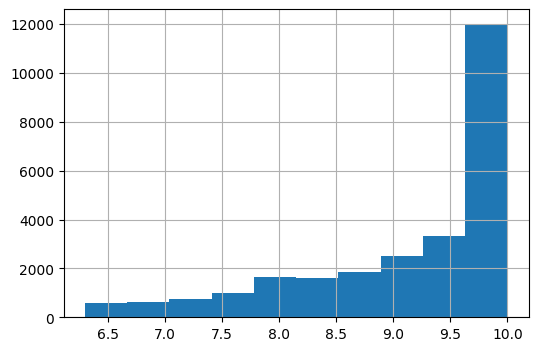

In [50]:
df2["Score"].hist(bins=10, figsize=(6,4))

Top 10 nationality có nhiều khách sạn nhất:
Nationality
Việt Nam          315
Hàn Quốc          250
Hoa Kỳ            177
Thái Lan          143
Úc                140
Malaysia          126
Vương quốc Anh    119
Trung Quốc        119
Canada            119
Nhật Bản          115
Name: Hotel_ID, dtype: int64


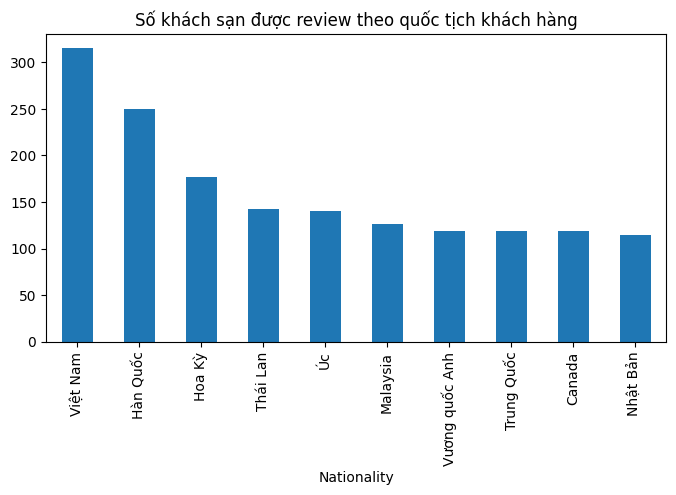

In [51]:
# 1. Số khách sạn theo nationality
hotel_nationality = df2.groupby("Nationality")["Hotel_ID"].nunique().sort_values(ascending=False)
print("Top 10 nationality có nhiều khách sạn nhất:")
print(hotel_nationality.head(10))

hotel_nationality.head(10).plot(kind="bar", figsize=(8,4), title="Số khách sạn được review theo quốc tịch khách hàng")
plt.show()


Số khách sạn theo hạng sao:
Hotel_Rank_Num
0.0    473
1.0      2
1.5      4
2.0     12
2.5      2
3.0     42
3.5     16
4.0     54
4.5     12
5.0    123
Name: Hotel_ID, dtype: int64


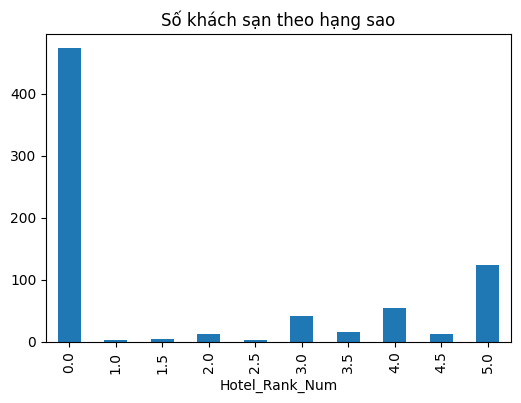

In [52]:
# 2. Số khách sạn theo hạng sao (Hotel_Rank_Num)
hotel_rank_count = df1.groupby("Hotel_Rank_Num")["Hotel_ID"].nunique()
print("\nSố khách sạn theo hạng sao:")
print(hotel_rank_count)

hotel_rank_count.plot(kind="bar", figsize=(6,4), title="Số khách sạn theo hạng sao")
plt.show()

Như vậy có khoảng gần 500 khách sạn không có sao 

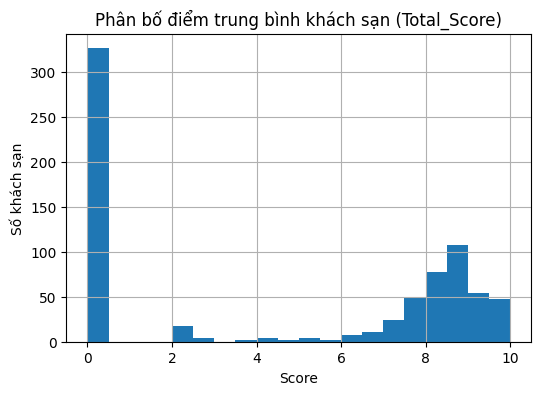

In [53]:
# 3. Số khách sạn theo total_score
hotel_score = df1.groupby("Hotel_ID")["Total_Score"].mean()
hotel_score.hist(bins=20, figsize=(6,4))
plt.title("Phân bố điểm trung bình khách sạn (Total_Score)")
plt.xlabel("Score")
plt.ylabel("Số khách sạn")
plt.show()

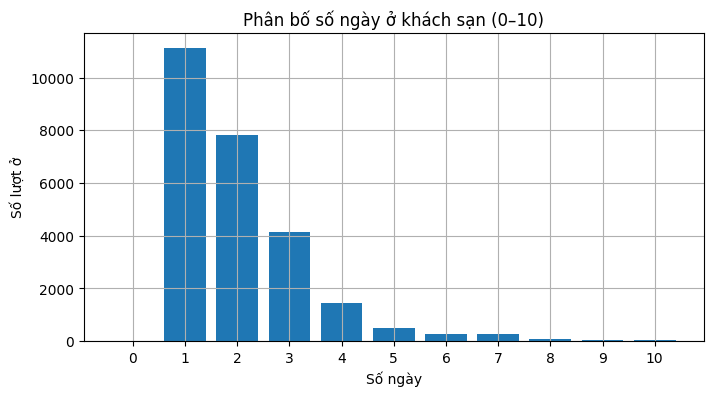

In [54]:
# 4. Số ngày ở khách sạn
max_day = 10

# Histogram với bin edges là từng số nguyên
bins = range(0, max_day + 2)  # +2 để include cả max_day
df2[df2["Days"] <= max_day]["Days"].hist(bins=bins, figsize=(8,4), align="left", rwidth=0.8)

plt.title("Phân bố số ngày ở khách sạn (0–10)")
plt.xlabel("Số ngày")
plt.ylabel("Số lượt ở")
plt.xticks(range(0, max_day+1))  # hiển thị ticks nguyên
plt.show()


Top 10 Room Type được chọn nhiều nhất:
Room_Type
Phòng Loại Sang                    550
Superior hướng thành phố           547
Phòng Superior                     492
Deluxe hướng thành phố             420
Phòng Loại Sang Hướng Đại Dương    365
Phòng Superior Giường Đôi          356
Phòng Standard giường đôi          318
Phòng Cao Cấp Cho Hai Người        314
Deluxe giường đôi Hướng phố        244
Deluxe 2 giường Hướng phố          241
Name: count, dtype: int64


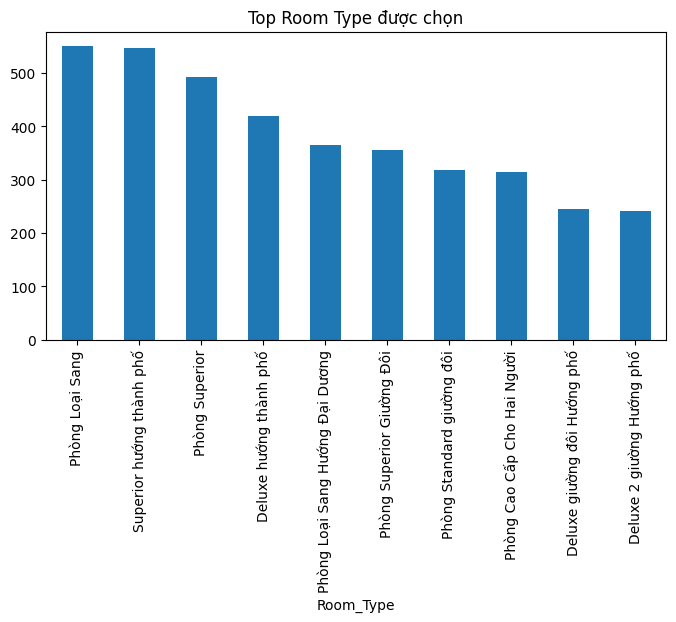

In [55]:
# 5. Top room type
room_type = df2["Room_Type"].value_counts().head(10)
print("\nTop 10 Room Type được chọn nhiều nhất:")
print(room_type)

room_type.plot(kind="bar", figsize=(8,4), title="Top Room Type được chọn")
plt.show()

### Insight Business

In [56]:
df1.columns

Index(['num', 'Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Total_Score',
       'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money',
       'Comfort_and_room_quality', 'comments_count', 'Hotel_Description',
       'Hotel_Rank_Num'],
      dtype='object')

In [57]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean'],
      dtype='object')

##### Hàm tìm hotel theo id hoặc key word trả ra thông tin dạng bảng 

In [49]:
def get_hotel_overview(hotels_df, keyword=None, hotel_id=None):
    cols = [
        "Hotel_ID", "Hotel_Name", "Hotel_Rank_Num", "Hotel_Address", "Total_Score",
        "Location", "Cleanliness", "Service", "Facilities", "Value_for_money",
        "Comfort_and_room_quality", "comments_count"
    ]
    
    # Truy vấn theo Hotel_ID
    if hotel_id is not None:
        result = hotels_df[hotels_df["Hotel_ID"] == hotel_id][cols]
        if result.empty:
            return f"❌ Không tìm thấy khách sạn với ID: {hotel_id}"
        return result.reset_index(drop=True)
    
    # Truy vấn theo keyword (hotel name)
    if keyword is not None:
        matched = hotels_df[hotels_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
        if matched.empty:
            return f"❌ Không tìm thấy khách sạn với từ khóa: {keyword}"
        return matched[cols].reset_index(drop=True)
    
    return "⚠️ Cần nhập ít nhất một trong hai: keyword hoặc hotel_id"


Gọi hàm Tìm theo từ khóa

In [59]:
# Tìm theo từ khóa
get_hotel_overview(df1, keyword="Mường Thanh")

,Hotel_ID,Hotel_Name,Hotel_Rank_Num,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5.0,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269
1,18_11,Mường Thanh Nha Trang Poli Apartment,0.0,"3 Phạm Văn Đồng, Vĩnh Hải, Vĩnh Phước, Nha Tra...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,26_25,"Chung cư 60 m² 2 phòng ngủ, 1 phòng tắm riêng ...",0.0,"Vĩnh Phước, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,21_17,"Căn hộ 45 m² 1 phòng ngủ, 1 phòng tắm riêng ở ...",0.0,"Lộc Thọ, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,36_20,"Căn hộ 50 m² 2 phòng ngủ, 1 phòng tắm riêng ở ...",0.0,"Lộc Thọ, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,39_1,"Căn hộ 60 m² 2 phòng ngủ, 1 phòng tắm riêng ở ...",0.0,"Vĩnh Phước, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,40_15,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",0.0,"Xương Huân, Nha Trang, Việt Nam",10.0,10.0,10.0,10.0,10.0,10.0,0.0,1
7,40_16,"Căn hộ 70 m² 3 phòng ngủ, 2 phòng tắm riêng ở ...",0.0,"Vĩnh Phước, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,29_11,"Căn hộ 70 m² 3 phòng ngủ, 2 phòng tắm riêng ở ...",0.0,"Vĩnh Phước, Nha Trang, Việt Nam",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,27_23,Căn hộ Mường Thanh Viễn Triều Nha Trang (Mường...,0.0,"3 pham van dong, Vĩnh Phước, Nha Trang, Việt N...",7.7,8.3,7.4,7.9,7.4,7.6,0.0,5


Gọi hàm Tìm theo id khách sạn

In [60]:
get_hotel_overview(df1, hotel_id="1_1")

,Hotel_ID,Hotel_Name,Hotel_Rank_Num,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5.0,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269


##### Hàm tìm khách sạn theo ID hoặc key word trả ra biểu đồ phân tích

In [51]:
def analyze_strengths_weaknesses(hotels_df, keyword=None, hotel_id=None):
    # Các cột cần so sánh
    cols = ["Hotel_Rank_Num","Total_Score", "Location", "Cleanliness", "Service", 
            "Facilities", "Value_for_money", "Comfort_and_room_quality"]
    
    # --- Tìm khách sạn ---
    if hotel_id is not None:
        hotel = hotels_df[hotels_df["Hotel_ID"] == hotel_id]
    elif keyword is not None:
        hotel = hotels_df[hotels_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    else:
        return "⚠️ Cần nhập keyword hoặc hotel_id"
    
    if hotel.empty:
        return "❌ Không tìm thấy khách sạn"
    
    hotel = hotel.iloc[0]   # lấy record đầu tiên
    
    # --- Tính trung bình toàn hệ thống ---
    system_avg = hotels_df[cols].mean()
    
    # --- Điểm của khách sạn ---
    hotel_scores = hotel[cols]
    
    # --- Ghép dữ liệu cho vẽ ---
    compare_df = (
        pd.DataFrame({"Hotel": hotel_scores, "System_Avg": system_avg})
        .reset_index()
        .rename(columns={"index": "Criteria"})
    )
    
    # --- Vẽ biểu đồ ---
    compare_df.plot(x="Criteria", kind="bar", figsize=(10,5))
    plt.title(f"So sánh điểm khách sạn '{hotel['Hotel_Name']}' với trung bình hệ thống")
    plt.ylabel("Điểm")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # --- Nhận xét điểm mạnh & yếu ---
    strengths = compare_df[compare_df["Hotel"] > compare_df["System_Avg"]]["Criteria"].tolist()
    weaknesses = compare_df[compare_df["Hotel"] < compare_df["System_Avg"]]["Criteria"].tolist()
    
    return {
        "Hotel_Name": hotel["Hotel_Name"],
        "Strengths": strengths,
        "Weaknesses": weaknesses
    }

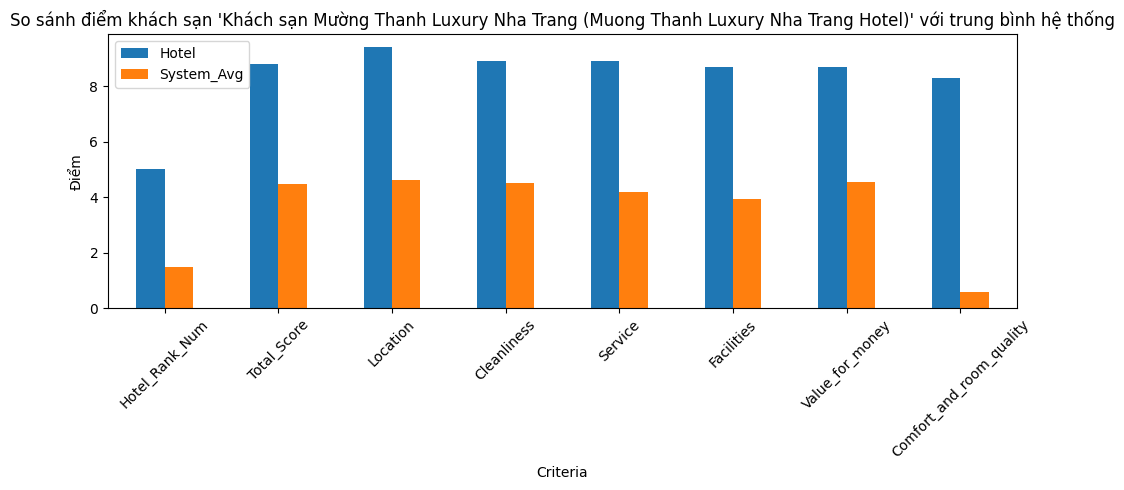

{'Hotel_Name': 'Khách sạn Mường Thanh Luxury Nha Trang (Muong Thanh Luxury Nha Trang Hotel)', 'Strengths': ['Hotel_Rank_Num', 'Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality'], 'Weaknesses': []}


In [62]:
result = analyze_strengths_weaknesses(df1, keyword="Mường Thanh")
print(result)

##### Hàm tìm theo ID hoặc key word cho chủ khách sạn, trả các biểu đồ thống kê cho khách sạn đó Quốc tịch, nhóm khách, xu hướng theo thời gian

In [52]:
def customer_statistics(reviews_df, keyword=None, hotel_id=None):
    # --- lọc review theo hotel ---
    if hotel_id is not None:
        data = reviews_df[reviews_df["Hotel_ID"] == hotel_id]
    elif keyword is not None:
        data = reviews_df[reviews_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    else:
        return "⚠️ Cần nhập keyword hoặc hotel_id"
    
    if data.empty:
        return "❌ Không có review cho khách sạn này"
    
    hotel_name = data["Hotel_Name"].iloc[0]
    print(f"📊 Thống kê khách hàng cho khách sạn: {hotel_name}\n")
    
    # --- Quốc tịch ---
    nationality_count = data["Nationality"].value_counts().head(10)
    nationality_count.plot(kind="bar", figsize=(8,4))
    plt.title("Top 10 quốc tịch khách hàng")
    plt.xlabel("Quốc tịch")
    plt.ylabel("Số lượng khách hàng")
    plt.xticks(rotation=45)
    plt.show()
    
    # --- Nhóm khách ---
    group_count = data["Group_Name"].value_counts()
    group_count.plot(kind="bar", figsize=(6,4))
    plt.title("Phân bố nhóm khách")
    plt.xlabel("Nhóm khách")
    plt.ylabel("Số lượng khách hàng")
    plt.xticks(rotation=45)
    plt.show()
    
    # --- Xu hướng theo thời gian ---
    trend = data.groupby(data["Review_Date"].dt.to_period("M")).size()
    trend.index = trend.index.to_timestamp()  # convert period -> timestamp để vẽ
    trend.plot(figsize=(10,4))
    plt.title("Xu hướng review theo thời gian")
    plt.xlabel("Thời gian")
    plt.ylabel("Số lượng khách hàng")
    plt.show()

    # ---  Xu hướng Số ngày thuê tại khách sạn---
    days_dist = data["Days"].value_counts().sort_index()
    days_dist.plot(kind="bar", figsize=(8,4))
    plt.title("Phân bố số ngày khách ở (Days)")
    plt.xlabel("Số ngày ở")
    plt.ylabel("Số lượng khách hàng")
    plt.show()

    # ---  Xu hướng theo tháng thuê tại khách sạn---
    month_dist = data["Month_Stay"].value_counts().sort_index()
    full_months = pd.Series(0, index=np.arange(1,13))
    month_dist = full_months.add(month_dist, fill_value=0).astype(int)
    month_dist = data["Month_Stay"].value_counts().sort_index()
    month_dist.plot(kind="line", marker="o", figsize=(8,4))
    plt.title("Xu hướng khách ở theo tháng")
    plt.xlabel("Tháng")
    plt.ylabel("Số lượng khách")
    plt.grid(True, linestyle="--", alpha=0.6)
    for x, y in zip(month_dist.index, month_dist.values):
        plt.text(x, y+0.5, str(y), ha="center", fontsize=9)
    plt.show()
    
    # ---  Xu hướng Room type thuê tại khách sạn---    
    room_dist = data["Room_Type"].value_counts().head(5)  # top 10 loại phòng
    plt.figure(figsize=(5,5))
    plt.pie(room_dist,labels=room_dist.index,autopct="%1.1f%%",startangle=90,counterclock=False)
    plt.title("Tỷ lệ top 10 loại phòng được đặt")
    plt.show()

    # ---  Điểm đánh giá của khách hàng---     
    plt.figure(figsize=(7,4))
    plt.hist(data["Score"], bins=range(0,11), edgecolor="black", alpha=0.7)

    # Vẽ đường trung bình khách sạn
    hotel_score = data["Mean_Reviewer_Score"].mean()
    plt.axvline(hotel_score, color="red", linestyle="--", linewidth=2, label=f"Hotel Mean = {hotel_score:.2f}")

    plt.title(f"Phân bổ điểm đánh giá (Score)")
    plt.xlabel("Điểm khách hàng chấm")
    plt.ylabel("Số lượng khách hàng")
    plt.xticks(range(0,11))
    plt.legend()
    plt.show()

    return {
        "Top_Nationalities": nationality_count.to_dict(),
        "Group_Distribution": group_count.to_dict(),
        "Review_Trend": trend.to_dict(),
        "Days_Distribution": days_dist.to_dict(),
        "Month_Distribution": month_dist.to_dict(),
        "Room_Distribution": room_dist.to_dict(),
        "Reviewer_Score": hotel_score,
    }

📊 Thống kê khách hàng cho khách sạn: Khách sạn Mường Thanh Luxury Nha Trang (Muong Thanh Luxury Nha Trang Hotel)



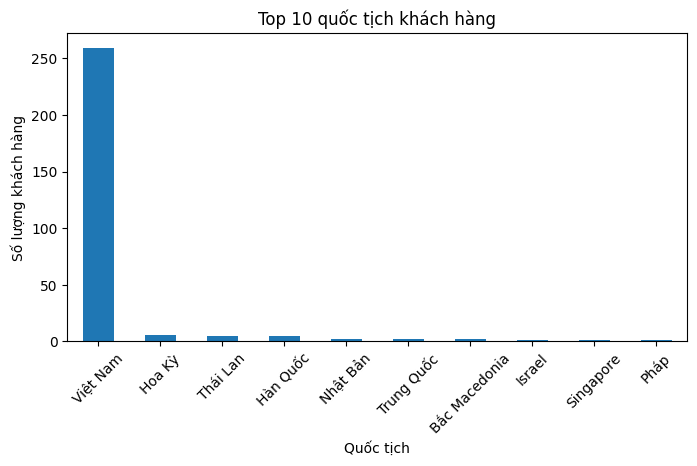

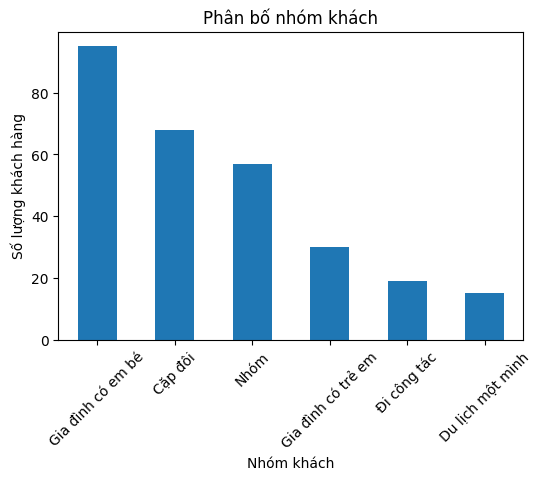

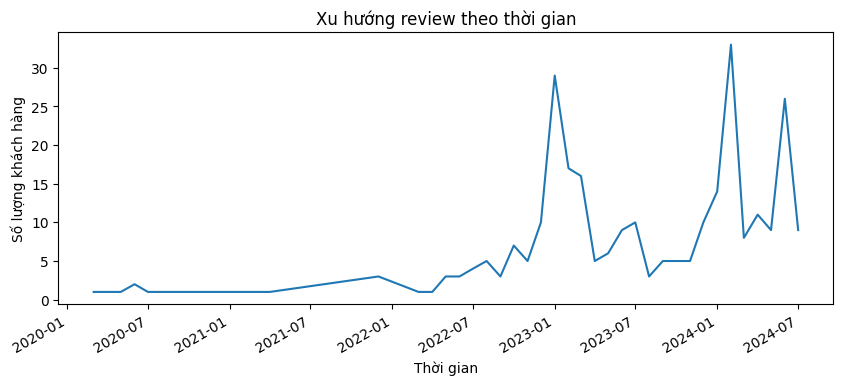

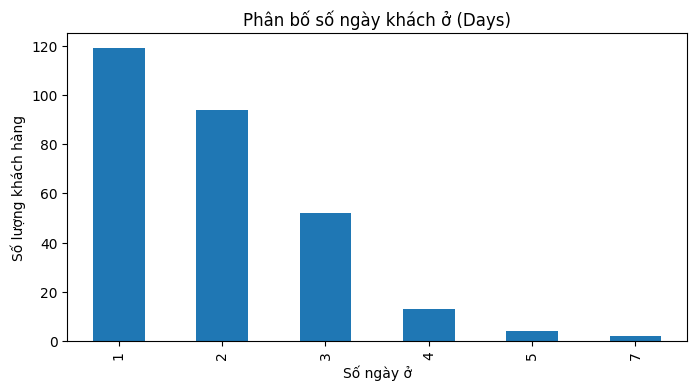

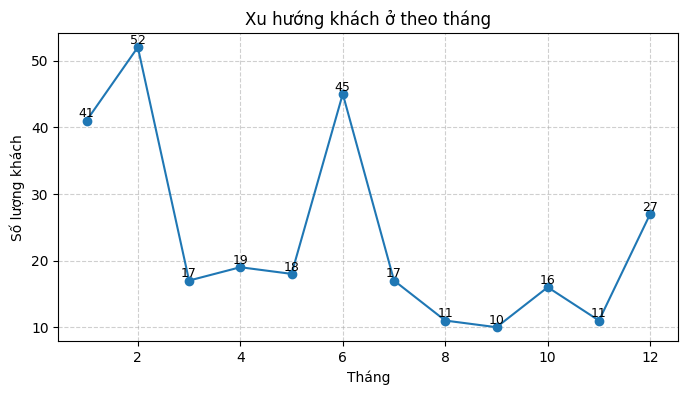

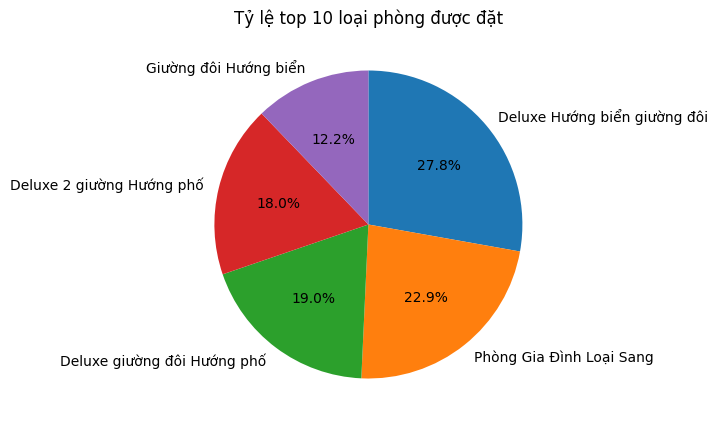

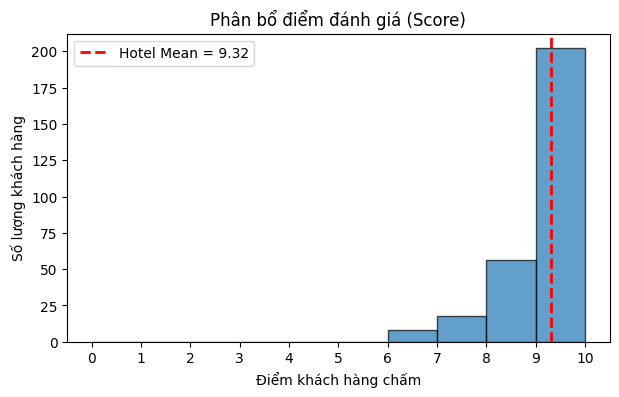

dict_keys(['Top_Nationalities', 'Group_Distribution', 'Review_Trend', 'Days_Distribution', 'Month_Distribution', 'Room_Distribution', 'Reviewer_Score'])


In [64]:
result = customer_statistics(df2, keyword="Mường Thanh")
print(result.keys())

##### Clean body review tiếng nước ngoài

Vì bảng df2 đang có những cmt tiếng anh, tiếng việt và các thứ tiếng khác nên không thể cho insight các từ khóa tích cực, tiêu cực về khách sạn đó.
Vậy nên, bảng df2 sẽ được copy thành bảng df3 và loại bỏ các thứ tiếng khác ngoại trừ các body review tiếng anh và tiếng việt đã được xử lý ở trên

In [71]:
df3 = df2

In [48]:
from langdetect import detect

In [49]:
def is_not_vi_en(text):
    try:
        lang = detect(text)
        return lang not in ['vi', 'en']
    except:
        return False 

In [50]:
df2['non_vi_en'] = df2['Body_clean'].apply(is_not_vi_en)

In [51]:
num_non_vi_en = df2['non_vi_en'].sum()
num_non_vi_en

6769

In [52]:
# Giữ lại những dòng có non_vi_en == False
df2 = df2[df2['non_vi_en'] == False].copy()

In [53]:
# Loại bỏ cmt chỉ có ký tự
def has_letters(text):
    if pd.isna(text):
        return False
    # Kiểm tra có ít nhất 1 ký tự chữ cái (Latin hoặc tiếng Việt có dấu)
    return bool(re.search(r'[A-Za-zÀ-ỹà-ỹ]', text))

In [54]:
# Lọc giữ lại comment có chữ cái
df2 = df2[df2['Body_clean'].apply(has_letters)].copy()

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17510 entries, 0 to 80185
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             17510 non-null  object        
 1   Reviewer_Name        17510 non-null  object        
 2   Nationality          17510 non-null  object        
 3   Group_Name           17510 non-null  object        
 4   Room_Type            17510 non-null  object        
 5   Score                17510 non-null  float64       
 6   Score_Level          17510 non-null  object        
 7   Title                17510 non-null  object        
 8   Body                 17510 non-null  object        
 9   Review_Date          17510 non-null  datetime64[ns]
 10  Hotel_Name           17510 non-null  object        
 11  Days                 17510 non-null  int32         
 12  Month_Stay           17510 non-null  int32         
 13  Mean_Reviewer_Score  17510 non-null 

In [56]:
df2.head(2)

,Hotel_ID,Reviewer_Name,Nationality,Group_Name,Room_Type,Score,Score_Level,Title,Body,Review_Date,Hotel_Name,Days,Month_Stay,Mean_Reviewer_Score,Review_ID_real,Body_clean,non_vi_en
0,1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,3,7,9.407407,1_1_MARIKO_Nhật Bản_2023-07-30,chủ nhân 4 đêm. Nhân viên thân thiện. Tầm phòn...,False
1,1_1,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,1,9,9.407407,1_1_Hong_Việt Nam_2022-09-05,Lựa Mường giá phù hợp. Online ưu đãi. Bữa phú ...,False


##### Hàm tìm word_cloud

In [80]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [81]:
def hotel_wordcloud(df, keyword=None, hotel_id=None, body_col='Body_clean', hotel_name_col='Hotel_Name', hotel_id_col='Hotel_ID'):
    # Lọc dữ liệu theo hotel_id hoặc keyword
    if hotel_id is not None:
        hotel_df = df[df[hotel_id_col] == hotel_id]
    elif keyword is not None:
        hotel_df = df[df[hotel_name_col].str.contains(keyword, case=False, na=False)]
    else:
        print("❌ Bạn cần nhập keyword hoặc hotel_id")
        return
    
    if hotel_df.empty:
        print("❌ Không tìm thấy khách sạn phù hợp")
        return
    
    # Ghép toàn bộ review body lại
    text = " ".join(hotel_df[body_col].dropna().astype(str).tolist())
    
    if not text.strip():
        print("❌ Không có review text để tạo wordcloud")
        return
    
    # Tạo wordcloud
    wc = WordCloud(width=800, height=400, background_color="white",
                   max_words=200, collocations=False).generate(text)
    
    # Vẽ
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    
    title = hotel_df[hotel_name_col].iloc[0] if not hotel_df.empty else "Hotel"
    plt.title(f"WordCloud - {title}", fontsize=16)
    plt.show()

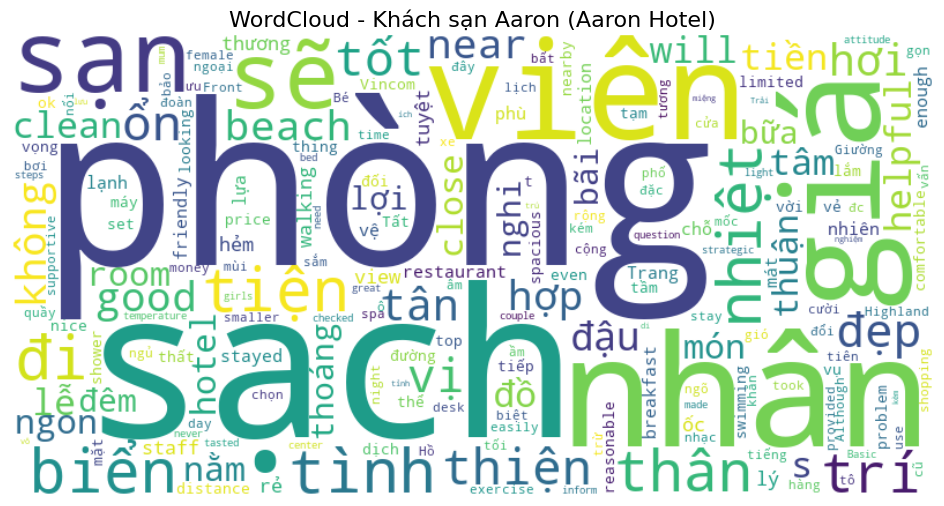

In [82]:
# Tìm theo hotel_id
hotel_wordcloud(df3, hotel_id="1_3")

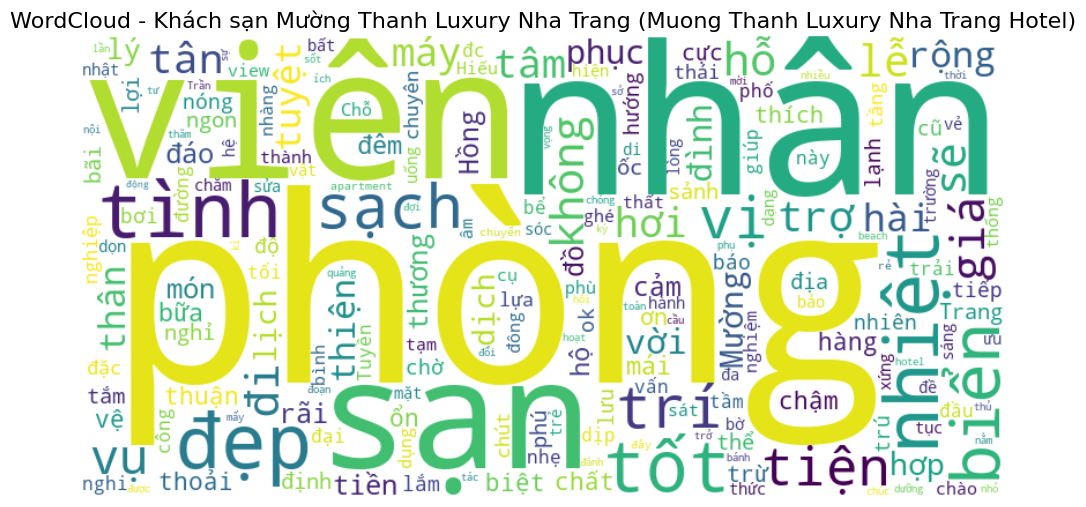

In [83]:
# Tìm theo keyword trong tên khách sạn
hotel_wordcloud(df3, keyword="Mường Thanh")

### Content-based Filtering

##### Cosine_similarity

In [48]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean'],
      dtype='object')

In [49]:
df1.columns

Index(['num', 'Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Total_Score',
       'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money',
       'Comfort_and_room_quality', 'comments_count', 'Hotel_Description',
       'Hotel_Rank_Num'],
      dtype='object')

In [59]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean', 'non_vi_en'],
      dtype='object')

In [57]:
hotel_corpus = df2.groupby("Hotel_ID")["Body_clean"].apply(lambda x: " ".join(x)).reset_index()

In [58]:
hotel_corpus = hotel_corpus.merge(df1[["Hotel_ID", "Hotel_Name"]], on="Hotel_ID", how="left")
hotel_corpus = hotel_corpus.merge(df2[["Hotel_ID", "Room_Type"]], on="Hotel_ID", how="left")
hotel_corpus = hotel_corpus.merge(df1[["Hotel_ID", "Hotel_Address","Hotel_Description"]], on="Hotel_ID", how="left")

In [59]:
hotel_corpus.head(2)

,Hotel_ID,Body_clean,Hotel_Name,Room_Type,Hotel_Address,Hotel_Description
0,10_1,thời vẻ nghĩa was similar with pictures good. ...,Biệt thự Valentine Nha Trang B8 (Valentine vil...,Villa riêng,"Vĩnh Trường, Nha Trang, Việt Nam",Tọa lạc tại vị trí trung tâm thành phố Nha Tra...
1,10_1,thời vẻ nghĩa was similar with pictures good. ...,Biệt thự Valentine Nha Trang B8 (Valentine vil...,Villa riêng,"Vĩnh Trường, Nha Trang, Việt Nam",Tọa lạc tại vị trí trung tâm thành phố Nha Tra...


In [60]:
cols_to_merge = ["Body_clean", "Hotel_Name", "Room_Type", "Hotel_Address", "Hotel_Description"]
hotel_corpus[cols_to_merge] = hotel_corpus[cols_to_merge].fillna("").astype("string")

In [61]:
hotel_corpus["Content"] = hotel_corpus[cols_to_merge].agg(" ".join, axis=1)

In [62]:
check_duplicate_column(hotel_corpus,"Content")

Số dòng trùng theo cột 'Content': 15695


,Hotel_ID,Body_clean,Hotel_Name,Room_Type,Hotel_Address,Hotel_Description,Content
1,10_1,thời vẻ nghĩa was similar with pictures good. ...,Biệt thự Valentine Nha Trang B8 (Valentine vil...,Villa riêng,"Vĩnh Trường, Nha Trang, Việt Nam",Tọa lạc tại vị trí trung tâm thành phố Nha Tra...,thời vẻ nghĩa was similar with pictures good. ...
4,10_12,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích...",Sata Hotel,Deluxe hướng thành phố,"24E Nguyen Thien Thuat, Tan Lap, Nha Trang, Tâ...",Khám phá Sata Hotel - Khách sạn 3 sao tại Nha ...,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích..."
6,10_12,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích...",Sata Hotel,Deluxe hướng thành phố,"24E Nguyen Thien Thuat, Tan Lap, Nha Trang, Tâ...",Khám phá Sata Hotel - Khách sạn 3 sao tại Nha ...,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích..."
7,10_12,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích...",Sata Hotel,Phòng Superior hướng thành phố,"24E Nguyen Thien Thuat, Tan Lap, Nha Trang, Tâ...",Khám phá Sata Hotel - Khách sạn 3 sao tại Nha ...,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích..."
9,10_12,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích...",Sata Hotel,Phòng Senior Deluxe hướng biển,"24E Nguyen Thien Thuat, Tan Lap, Nha Trang, Tâ...",Khám phá Sata Hotel - Khách sạn 3 sao tại Nha ...,"trì hoãn hành lý máy bay, sạn 3 sáng, cảm kích..."
...,...,...,...,...,...,...,...
17505,9_7,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón...",Vinpearl Resort Nha Trang,Phòng Loại Sang Giường Đôi,"Đảo Hòn Tre, Phường Vĩnh Nguyên , Hòn Tre, Nha...",Vinpearl Resort Nha Trang - Kỳ nghỉ tuyệt vời ...,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón..."
17506,9_7,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón...",Vinpearl Resort Nha Trang,Phòng Loại Sang Giường Đôi,"Đảo Hòn Tre, Phường Vĩnh Nguyên , Hòn Tre, Nha...",Vinpearl Resort Nha Trang - Kỳ nghỉ tuyệt vời ...,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón..."
17507,9_7,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón...",Vinpearl Resort Nha Trang,Phòng Loại Sang Giường Đôi,"Đảo Hòn Tre, Phường Vĩnh Nguyên , Hòn Tre, Nha...",Vinpearl Resort Nha Trang - Kỳ nghỉ tuyệt vời ...,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón..."
17508,9_7,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón...",Vinpearl Resort Nha Trang,Phòng Grand Deluxe hướng biển giường đôi,"Đảo Hòn Tre, Phường Vĩnh Nguyên , Hòn Tre, Nha...",Vinpearl Resort Nha Trang - Kỳ nghỉ tuyệt vời ...,"Phòng rộng lớn, gió mát chịu, máy lạnh đêm nón..."


In [63]:
hotel_corpus = hotel_corpus.drop_duplicates(subset=["Content"], keep="first")

In [64]:
hotel_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 17470
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hotel_ID           1815 non-null   object
 1   Body_clean         1815 non-null   string
 2   Hotel_Name         1815 non-null   string
 3   Room_Type          1815 non-null   string
 4   Hotel_Address      1815 non-null   string
 5   Hotel_Description  1815 non-null   string
 6   Content            1815 non-null   object
dtypes: object(2), string(5)
memory usage: 113.4+ KB


In [65]:
hotel_corpus['Content_wt'] = hotel_corpus['Content'].fillna("").astype("string")

In [66]:
hotel_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 17470
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hotel_ID           1815 non-null   object
 1   Body_clean         1815 non-null   string
 2   Hotel_Name         1815 non-null   string
 3   Room_Type          1815 non-null   string
 4   Hotel_Address      1815 non-null   string
 5   Hotel_Description  1815 non-null   string
 6   Content            1815 non-null   object
 7   Content_wt         1815 non-null   string
dtypes: object(2), string(6)
memory usage: 127.6+ KB


In [67]:
# word_tokenize
hotel_corpus["Content_wt"]= hotel_corpus["Content"].apply(lambda x: tokenize(x))

In [72]:
hotel_corpus.to_csv("data_clean/hotel_corpus_cosine.csv", index=False, encoding="utf-8-sig")

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# Vector hóa TF-IDF
vectorizer = TfidfVectorizer(analyzer='word')
tfidf_matrix = vectorizer.fit_transform(hotel_corpus['Content_wt'])

In [76]:
# Save model + matrix
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")
joblib.dump(tfidf_matrix, "models/tfidf_matrix.pkl")

['models/tfidf_matrix.pkl']

In [70]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [77]:
joblib.dump(cosine_sim, "models/cosine_similarity.pkl")

['models/cosine_similarity.pkl']

In [75]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,...,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814
0,1.000000,0.075295,0.075277,0.075106,0.075123,0.075153,0.075094,0.075273,0.069633,0.069655,...,0.059674,0.059629,0.059652,0.059780,0.059602,0.059655,0.059609,0.059625,0.059634,0.064551
1,0.075295,1.000000,0.999868,0.999874,0.999932,0.999890,0.999811,0.999888,0.495188,0.495450,...,0.549365,0.548629,0.549518,0.549405,0.549055,0.549013,0.549119,0.549023,0.548819,0.548886
2,0.075277,0.999868,1.000000,0.999830,0.999800,0.999821,0.999917,0.999844,0.495003,0.495152,...,0.549446,0.548710,0.549625,0.549486,0.549163,0.549121,0.549226,0.549104,0.548927,0.548967
3,0.075106,0.999874,0.999830,1.000000,0.999820,0.999841,0.999761,0.999986,0.494879,0.495028,...,0.549489,0.548753,0.549682,0.549542,0.549219,0.549163,0.549283,0.549147,0.548969,0.549010
4,0.075123,0.999932,0.999800,0.999820,1.000000,0.999836,0.999806,0.999820,0.495683,0.495902,...,0.550087,0.549353,0.550214,0.550114,0.549775,0.549762,0.549815,0.549747,0.549543,0.549609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,0.059655,0.549013,0.549121,0.549163,0.549762,0.548971,0.549727,0.549088,0.627071,0.626888,...,0.999474,0.999393,0.999546,0.999097,0.999479,1.000000,0.999466,0.999366,0.999488,0.999282
1811,0.059609,0.549119,0.549226,0.549283,0.549815,0.549076,0.549779,0.549193,0.626815,0.626677,...,0.999807,0.999722,0.999920,0.999307,0.999987,0.999466,1.000000,0.999695,0.999978,0.999450
1812,0.059625,0.549023,0.549104,0.549147,0.549747,0.548981,0.549712,0.549071,0.627618,0.627511,...,0.999706,0.999668,0.999776,0.999210,0.999682,0.999366,0.999695,1.000000,0.999717,0.999395
1813,0.059634,0.548819,0.548927,0.548969,0.549543,0.548777,0.549508,0.548894,0.626949,0.626811,...,0.999800,0.999744,0.999898,0.999286,0.999966,0.999488,0.999978,0.999717,1.000000,0.999471


In [78]:
def recommend_hotels_by_keyword(hotel_corpus, cosine_sim, keyword, top_k=5):
    # Reset index để mapping đúng
    hotel_corpus = hotel_corpus.reset_index(drop=True)

    # Tìm khách sạn theo keyword (chứa trong tên)
    matches = hotel_corpus[hotel_corpus["Hotel_Name"].str.contains(keyword, case=False, na=False)]

    if matches.empty:
        print(f"❌ Không tìm thấy khách sạn nào chứa từ khóa '{keyword}'")
        return pd.DataFrame()

    all_results = []

    for idx in matches.index:
        src_id = hotel_corpus.loc[idx, "Hotel_ID"]
        src_name = hotel_corpus.loc[idx, "Hotel_Name"]

        # Tính similarity
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Loại chính nó
        sim_scores = [(i, score) for i, score in sim_scores if i != idx]

        # Lấy top-k và tránh trùng hotel_id
        seen_ids = set()
        count = 0
        for i, score in sim_scores:
            hid = hotel_corpus.loc[i, "Hotel_ID"]
            if hid not in seen_ids:
                seen_ids.add(hid)
                all_results.append({
                    "Source_Hotel_ID": src_id,
                    "Source_Hotel_Name": src_name,
                    "Recommended_Hotel_ID": hid,
                    "Recommended_Hotel_Name": hotel_corpus.loc[i, "Hotel_Name"],
                    "Recommended_Hotel_Address": hotel_corpus.loc[i, "Hotel_Address"],
                    "Recommended_Hotel_Description": hotel_corpus.loc[i, "Hotel_Description"],
                    "Similarity": round(score, 3)
                })
                count += 1
            if count >= top_k:
                break

    return pd.DataFrame(all_results)

In [79]:
recommend_hotels_by_keyword(hotel_corpus, cosine_sim, keyword = "Mường Thanh", top_k=5)

,Source_Hotel_ID,Source_Hotel_Name,Recommended_Hotel_ID,Recommended_Hotel_Name,Recommended_Hotel_Address,Recommended_Hotel_Description,Similarity
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,1.000
1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,3_10,Khách sạn Dendro Gold (Dendro Gold Hotel ),"86/4 Tran Phu Street, Lộc Thọ, Nha Trang, Việt...",Khách sạn Dendro Gold - Kỳ nghỉ thú vị tại Nha...,0.824
2,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,2_11,Maris Hotel Nha Trang,"27 Trần Quang Khải, Phường Lộc Thọ, Thành phố ...",Maris Hotel Nha Trang - Nơi lưu trú đẳng cấp t...,0.812
3,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,20_2,Khách Sạn MerPerle Beach (MerPerle Beach Hotel),"88A Tran Phu Street, Lộc Thọ, Nha Trang, Việt ...",Khách Sạn MerPerle Beach - Nơi Lý Tưởng Cho Kỳ...,0.810
4,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,4_25,Diamond Bay Hotel,"20 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",Diamond Bay Hotel - Nơi lưu trú sang trọng tại...,0.802
...,...,...,...,...,...,...,...
105,40_15,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",41_22,Khách Sạn Nha Trang Pearl (Nha Trang Pearl Hotel),"2 Phan Boi Chau, Xuong Huan, Nha Trang City, K...",Khách Sạn Nha Trang Pearl - Nơi Lưu Trú Lý Tưở...,0.665
106,40_15,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",27_23,Căn hộ Mường Thanh Viễn Triều Nha Trang (Mường...,"3 pham van dong, Vĩnh Phước, Nha Trang, Việt N...",Căn hộ Mường Thanh Viễn Triều Nha Trang - Nơi ...,0.638
107,40_15,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",38_7,Khách Sạn Arima (Arima Hotel),"96B/12 Tran Phu Street, Loc Tho Ward, Lộc Thọ,...",Khách Sạn Arima - Nơi Lưu Trú Lý Tưởng Tại Nha...,0.629
108,40_15,"Căn hộ 68 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...",15_18,Muong Thanh Apartments,"60 Tran Phu_ Tầng Trệt, Lộc Thọ, Nha Trang, Vi...",Muong Thanh Apartments - Nơi lưu trú lý tưởng ...,0.625


##### Gensim

In [71]:
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_punctuation

In [72]:
hotel_corpus2 = hotel_corpus

In [73]:
hotel_corpus2 = hotel_corpus2.reset_index(drop=False)  
hotel_corpus2 = hotel_corpus2.rename(columns={'index':'original_index'})

In [74]:
hotel_corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     1815 non-null   int64 
 1   Hotel_ID           1815 non-null   object
 2   Body_clean         1815 non-null   string
 3   Hotel_Name         1815 non-null   string
 4   Room_Type          1815 non-null   string
 5   Hotel_Address      1815 non-null   string
 6   Hotel_Description  1815 non-null   string
 7   Content            1815 non-null   object
 8   Content_wt         1815 non-null   object
dtypes: int64(1), object(3), string(5)
memory usage: 127.7+ KB


In [75]:
processed_docs = [
    preprocess_string(doc, filters=[strip_punctuation, remove_stopwords]) 
    for doc in hotel_corpus2['Content_wt'].tolist()
]

In [76]:
# 2. Tạo dictionary và corpus
dictionary = corpora.Dictionary(processed_docs)
corpus_gensim = [dictionary.doc2bow(doc) for doc in processed_docs]

In [118]:
corpora.MmCorpus.serialize("models/corpus_gensim.mm", corpus_gensim)

In [105]:
dictionary.save("models/dictionary.dict")

In [77]:
# 3. TF-IDF model
tfidf = models.TfidfModel(corpus_gensim)
corpus_tfidf = tfidf[corpus_gensim]

In [107]:
tfidf.save("models/tfidf_gensim.model")

In [78]:
# 4. Similarity index
index = similarities.SparseMatrixSimilarity(corpus_tfidf, num_features=len(dictionary))

In [109]:
index.save("models/similarity_index.index")

In [79]:
df_1 = pd.DataFrame(index)
df_1

,0,1,2,3,4,5,6,7,8,9,...,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814
0,1.000000,0.004194,0.004194,0.004192,0.004194,0.004192,0.004192,0.004192,0.000749,0.000750,...,0.008040,0.008020,0.008071,0.012406,0.008049,0.008050,0.008050,0.008060,0.008050,0.012348
1,0.004194,1.000000,0.999974,0.999881,0.999989,0.999434,0.999435,0.999881,0.039368,0.039769,...,0.040336,0.040235,0.040544,0.040613,0.040552,0.040434,0.040556,0.040663,0.040439,0.040442
2,0.004194,0.999974,0.999999,0.999910,0.999965,0.999453,0.999455,0.999910,0.039280,0.039561,...,0.040414,0.040314,0.040632,0.040692,0.040640,0.040523,0.040644,0.040742,0.040527,0.040521
3,0.004192,0.999881,0.999910,1.000003,0.999873,0.999360,0.999362,1.000003,0.039261,0.039541,...,0.040395,0.040294,0.040612,0.040672,0.040620,0.040503,0.040624,0.040722,0.040507,0.040501
4,0.004194,0.999989,0.999965,0.999873,1.000002,0.999431,0.999433,0.999873,0.039415,0.039798,...,0.040389,0.040289,0.040598,0.040650,0.040600,0.040500,0.040592,0.040717,0.040493,0.040496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,0.008050,0.040434,0.040523,0.040503,0.040500,0.040401,0.040924,0.040504,0.054405,0.054435,...,0.997860,0.998190,0.999492,0.999365,0.999984,1.000000,0.999976,0.999286,0.999989,0.998249
1811,0.008050,0.040556,0.040644,0.040624,0.040592,0.040506,0.041028,0.040625,0.054332,0.054391,...,0.997856,0.998186,0.999488,0.999389,0.999989,0.999976,1.000001,0.999281,0.999985,0.998244
1812,0.008060,0.040663,0.040742,0.040722,0.040717,0.040630,0.041153,0.040724,0.054377,0.054440,...,0.997799,0.998133,0.999408,0.999300,0.999271,0.999286,0.999281,0.999999,0.999294,0.998188
1813,0.008050,0.040439,0.040527,0.040507,0.040493,0.040406,0.040929,0.040509,0.054291,0.054351,...,0.997872,0.998199,0.999503,0.999374,0.999977,0.999989,0.999985,0.999294,1.000001,0.998259


In [80]:
hotel_corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     1815 non-null   int64 
 1   Hotel_ID           1815 non-null   object
 2   Body_clean         1815 non-null   string
 3   Hotel_Name         1815 non-null   string
 4   Room_Type          1815 non-null   string
 5   Hotel_Address      1815 non-null   string
 6   Hotel_Description  1815 non-null   string
 7   Content            1815 non-null   object
 8   Content_wt         1815 non-null   object
dtypes: int64(1), object(3), string(5)
memory usage: 127.7+ KB


In [81]:
hotel_corpus2.to_csv("data_clean/hotel_corpus_gensim.csv", index=False, encoding="utf-8-sig")

In [112]:
def find_hotels_by_keyword(hotel_corpus2, keyword):
    """
    Trả về các khách sạn chứa từ khóa trong Hotel_Name
    """
    matches = hotel_corpus[hotel_corpus["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    if matches.empty:
        print(f"❌ Không tìm thấy khách sạn nào chứa từ khóa '{keyword}'")
        return pd.DataFrame()
    return matches

In [113]:
def get_topk_recommendations(hotel_corpus2, matches, corpus_gensim, tfidf, index, top_k=5):
    """
    hotel_corpus2: DataFrame đã reset_index
    matches: DataFrame các khách sạn khớp keyword, có cột 'pos' lưu vị trí trong corpus_gensim
    corpus_gensim: danh sách vector gensim
    tfidf: mô hình tfidf
    index: gensim.Similarity index
    top_k: số kết quả muốn trả về
    """
    results = []

    for _, row in matches.iterrows():
        corpus_pos = row['pos']
        query_bow = corpus_gensim[corpus_pos]
        sims = index[tfidf[query_bow]]

        # Sắp xếp similarity, loại chính nó
        sims_sorted = sorted(list(enumerate(sims)), key=lambda x: -x[1])
        topk = [(i, score) for i, score in sims_sorted if i != corpus_pos][:top_k]

        for i, score in topk:
            # Lấy thông tin khách sạn recommended
            hotel_info = hotel_corpus2.iloc[i]
            results.append({
                "Source_Hotel": row["Hotel_Name"],
                "Recommended_Hotel": hotel_info["Hotel_Name"],
                "Address": hotel_info.get("Hotel_Address", ""),
                "Description": hotel_info.get("Hotel_Description", ""),
                "Score": score
            })

    return pd.DataFrame(results)


In [114]:
keyword = "Oasis Retreat"
matches = hotel_corpus2[hotel_corpus2['Hotel_Name'].str.contains(keyword, case=False)].copy()
matches['pos'] = matches.index

In [121]:
matches

,original_index,Hotel_ID,Body_clean,Hotel_Name,Room_Type,Hotel_Address,Hotel_Description,Content,Content_wt,pos
203,2660,13_3,"ok, giá hợp lý 3 pn, giá tiền phù hợp đình nhắ...",Oasis Retreat - Muong Thanh Vien Trieu,Căn hộ 3 phòng ngủ,"3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...",Oasis Retreat - Muong Thanh Vien Trieu Làm ch...,"ok, giá hợp lý 3 pn, giá tiền phù hợp đình nhắ...","ok , giá hợp_lý 3 pn , giá tiền phù_hợp đình n...",203
204,2663,13_3,"ok, giá hợp lý 3 pn, giá tiền phù hợp đình nhắ...",Oasis Retreat - Muong Thanh Vien Trieu,Căn hộ Deluxe,"3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...",Oasis Retreat - Muong Thanh Vien Trieu Làm ch...,"ok, giá hợp lý 3 pn, giá tiền phù hợp đình nhắ...","ok , giá hợp_lý 3 pn , giá tiền phù_hợp đình n...",204
929,12927,2_10,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...",Oceanus Oasis Retreat Muong Thanh Vien Trieu,Căn Hộ 2 Phòng Ngủ,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...","lưu_trú tuyệt_vời Trang . cạnh bãi biển , đi b...",929
930,12928,2_10,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...",Oceanus Oasis Retreat Muong Thanh Vien Trieu,Căn hộ 3 phòng ngủ,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...","lưu_trú tuyệt_vời Trang . cạnh bãi biển , đi b...",930
931,12931,2_10,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...",Oceanus Oasis Retreat Muong Thanh Vien Trieu,Phòng Superior gia đình,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...","lưu_trú tuyệt_vời Trang . cạnh bãi biển , đi b...",931
932,12934,2_10,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...",Oceanus Oasis Retreat Muong Thanh Vien Trieu,Căn hộ 2 phòng ngủ hướng biển,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...","lưu_trú tuyệt_vời Trang . cạnh bãi biển , đi b...",932
933,12946,2_10,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...",Oceanus Oasis Retreat Muong Thanh Vien Trieu,Căn hộ Superior,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,"lưu trú tuyệt vời Trang. cạnh bãi biển, đi bơi...","lưu_trú tuyệt_vời Trang . cạnh bãi biển , đi b...",933


In [115]:
df_results = get_topk_recommendations(hotel_corpus2, matches, corpus_gensim, tfidf, index, top_k=5)


In [116]:
df_results = df_results.drop_duplicates(subset="Recommended_Hotel", keep="first").reset_index(drop=True).sort_values(by="Score", ascending=False).reset_index(drop=True)
df_results

,Source_Hotel,Recommended_Hotel,Address,Description,Score
0,Oasis Retreat - Muong Thanh Vien Trieu,Oasis Retreat - Muong Thanh Vien Trieu,"3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...",Oasis Retreat - Muong Thanh Vien Trieu\n\nLàm ...,0.999960
1,Oceanus Oasis Retreat Muong Thanh Vien Trieu,Oceanus Oasis Retreat Muong Thanh Vien Trieu,"Phạm Văn Đồng, Vĩnh Phước, Nha Trang, Việt Nam...",Oceanus Oasis Retreat Muong Thanh Vien Trieu -...,0.999266
2,Oasis Retreat - Muong Thanh Vien Trieu,Muong Thanh Beachfront Apartment Nha Trang,"03 Phạm Văn Đồng, Tòa Nhà OC2B - Mường Thanh V...",Muong Thanh Beachfront Apartment Nha Trang\n\n...,0.605492
3,Oasis Retreat - Muong Thanh Vien Trieu,HANZ Condo Hotel Muong Thanh Vien Trieu,"5 Phạm Văn Đồng, Muong Thanh Vien Trieu, Nha T...",HANZ Condo Hotel Muong Thanh Vien Trieu\n\nThứ...,0.477637
4,Oasis Retreat - Muong Thanh Vien Trieu,HANZ Muong Thanh Vien Trieu Condo Hotel,"5 Phạm Văn Đồng, Vĩnh Hải, Nha Trang, Khánh Hò...",HANZ Muong Thanh Vien Trieu Condo Hotel\n\nTận...,0.407900
